In [79]:
pip install cvlib

  Created wheel for cvlib: filename=cvlib-0.2.2-cp37-none-any.whl size=10043366 sha256=4c1ba5a6fadcfce479a4ac91b8ba016ee599eaead6b29b2ce90f3350c9c0f58b
  Stored in directory: C:\Users\dandoye\AppData\Local\pip\Cache\wheels\22\b7\0f\8d3ee1bf6f30d408e11250bd4d0a8270ffe22fb7b54a987380
  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12078 sha256=191a7e9a0334ae392421bf24ffa871b19bf4cc3d7e91b3b583e6d2efbe17c373
  Stored in directory: C:\Users\dandoye\AppData\Local\pip\Cache\wheels\c0\e9\6b\ea01090205e285175842339aa3b491adeb4015206cda272ff0
  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25853 sha256=aa9148780762a146ab4e306f69c707c2adef63136acffbc55acb6dc9a08d47ad
  Stored in directory: C:\Users\dandoye\AppData\Local\pip\Cache\wheels\16\84\1f\bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built cvlib progressbar imutils
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
plt.style.use('ggplot')

from skimage.io import imread_collection
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import cvlib as cv
from cvlib.object_detection import draw_bbox

Using TensorFlow backend.


# Data

In [5]:
train = pd.read_csv('train.csv')

from itertools import islice

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

col_names = ['model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']

train['PredictionString'] = [list(map(float, x)) for x in train['PredictionString'].str.split(" ")]
train['PredictionString'] = [list(chunk(x, 7)) for x in train['PredictionString']]
#train['PredictionString'] = [dict(zip(col_names, i)) for x in train['PredictionString'] for i in x]
train['cars'] = [len(x) for x in train['PredictionString']]
train

,ImageId,PredictionString,cars
0,ID_8a6e65317,"[(16.0, 0.254839, -2.57534, -3.10256, 7.96539,...",5
1,ID_337ddc495,"[(66.0, 0.163988, 0.192169, -3.12112, -3.17424...",8
2,ID_a381bf4d0,"[(43.0, 0.162877, 0.00519276, -3.02676, 2.1876...",25
3,ID_7c4a3e0aa,"[(43.0, 0.126957, -3.04442, -3.10883, -14.738,...",3
4,ID_8b510fad6,"[(37.0, 0.16017, 0.00862796, -3.0887, -3.04548...",19
...,...,...,...
4257,ID_de17ab626,"[(70.0, 0.177583, -0.023215, -3.08003, -25.368...",8
4258,ID_5a669e211,"[(12.0, 0.23817, -3.12745, 3.13929, -7.21988, ...",12
4259,ID_aa6ffba0a,"[(35.0, 0.166437, -0.497963, -3.12063, 12.6792...",16
4260,ID_29454123f,"[(70.0, 0.14292, 0.0290822, -3.12594, -3.42749...",7


# Camera Matrix

In [6]:
#camera matrix
fx = 2304.5479
fy = 2305.8757
cx = 1686.2379
cy = 1354.9849

camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Sample Image

In [7]:
image_num = 555
image_id = train['ImageId'][image_num]
image_labels = train['PredictionString'][image_num]
image_id, image_labels

('ID_86bb8b3d5',
 [(28.0, 0.16643, -0.0189796, -3.10639, -2.97495, 4.1584, 17.6383),
  (66.0, 0.0922343, 3.06958, -3.12448, -6.74933, 5.48623, 28.1906),
  (19.0, 0.158973, -3.14119, -3.13732, -6.53118, 7.82767, 43.759),
  (28.0, 0.111415, -0.0116207, -3.07668, -2.68431, 6.58645, 33.7366),
  (12.0, 0.167803, -2.90685, -3.12894, -1.34892, 11.7291, 69.4944),
  (70.0, 0.0975892, 0.00826225, -3.09395, 6.70368, 9.35214, 49.9699),
  (6.0, -0.0636958, -3.04351, -3.12925, 29.4124, 20.394, 120.493),
  (25.0, 0.276442, -0.407186, -3.10145, 24.2768, 14.6926, 88.3155),
  (16.0, 0.167804, -0.0477291, -3.12893, 0.232373, 16.89, 102.205),
  (76.0, 0.166436, 0.347849, -3.11666, 3.67893, 15.7349, 93.5031),
  (16.0, 0.166436, -0.00282167, -3.11665, 2.46897, 9.73054, 54.4367),
  (23.0, 0.25799, -1.82971, -3.03347, 27.7171, 16.1082, 85.2258),
  (16.0, 0.167805, 3.08563, -3.12894, -5.04609, 14.8629, 92.2308)])

# YOLO Object Detection

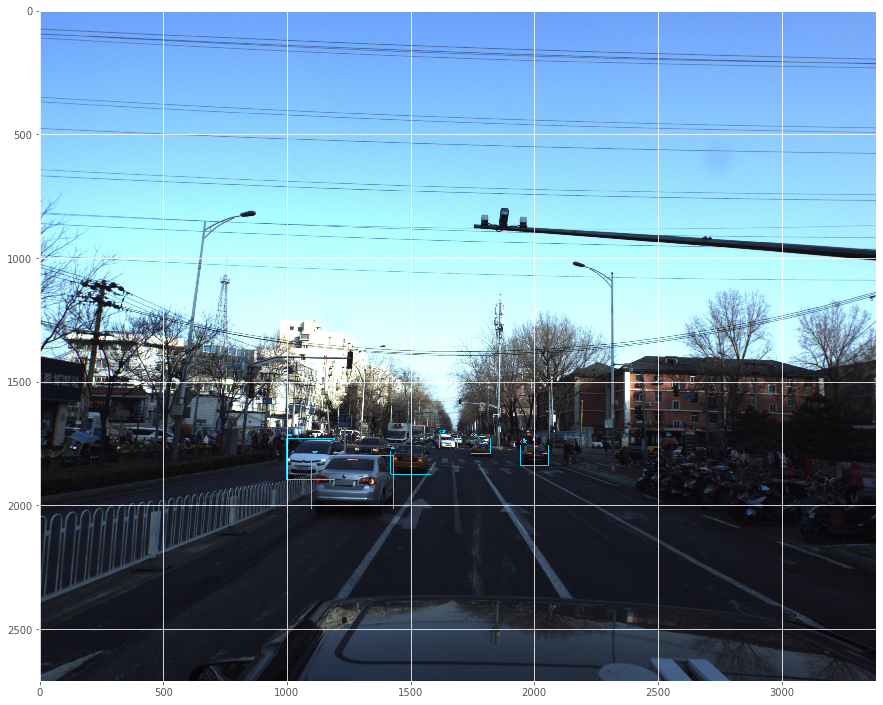

In [8]:
image = 'train_images/' + image_id + '.jpg'
image_viz = io.imread(image)
bbox, label, conf = cv.detect_common_objects(image_viz)
cars = bbox, label, conf
cars = [(bbox[n],label[n],conf[n]) for n in range(len(bbox)) if label[n] == 'car']
cars = np.array(cars).transpose()
output_image = draw_bbox(image_viz, cars[0], cars[1], cars[2])
plt.figure(figsize=(15,15))
plt.imshow(output_image)

In [13]:
cars

array([[list([1101, 1799, 1433, 2015]), list([1945, 1756, 2059, 1840]),
        list([1000, 1729, 1196, 1895]), list([1746, 1728, 1826, 1792]),
        list([1618, 1716, 1692, 1768]), list([1422, 1781, 1584, 1875])],
       ['car', 'car', 'car', 'car', 'car', 'car'],
       [0.9739475846290588, 0.8790131211280823, 0.8507072925567627,
        0.8047742247581482, 0.7915233373641968, 0.5289278626441956]],
      dtype=object)

# Find Centers

In [10]:
def camera_to_image(labels):
    xy_points = np.zeros((len(labels),2))
    i = 0
    for cars in labels:
        hc = np.dot(camera_matrix, np.array([cars[4], cars[5], cars[6]]))
        xy_points[i] = hc[:-1] / hc[-1]
        i += 1
    return np.int16(xy_points)

camera_to_image(image_labels)

array([[1297, 1898],
       [1134, 1803],
       [1342, 1767],
       [1502, 1805],
       [1641, 1744],
       [1995, 1786],
       [2248, 1745],
       [2319, 1738],
       [1691, 1736],
       [1776, 1743],
       [1790, 1767],
       [2435, 1790],
       [1560, 1726]], dtype=int16)

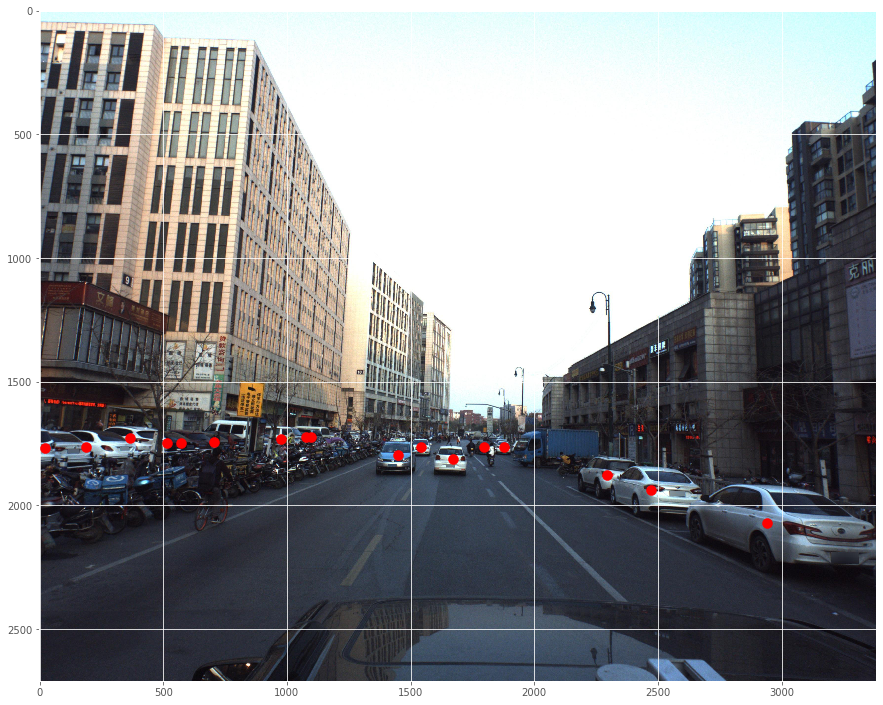

In [69]:
#def plot_centers(image_num):
plt.figure(figsize=(15,15))
plt.imshow(image_viz)
xy = camera_to_image(image_labels)
plt.scatter(xy[:,0], xy[:,1], color='red', s=100)
#plt.axis('off')

# Draw Circle

In [11]:
image_gray = color.rgb2gray(image_viz)
points = cars[0]
snake = seg.active_contour(image_gray, points, alpha = 0.06, beta = 0.3)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)

IndexError: too many indices for array

In [68]:
xy[1]

array([2473, 1939], dtype=int16)

KeyboardInterrupt: 

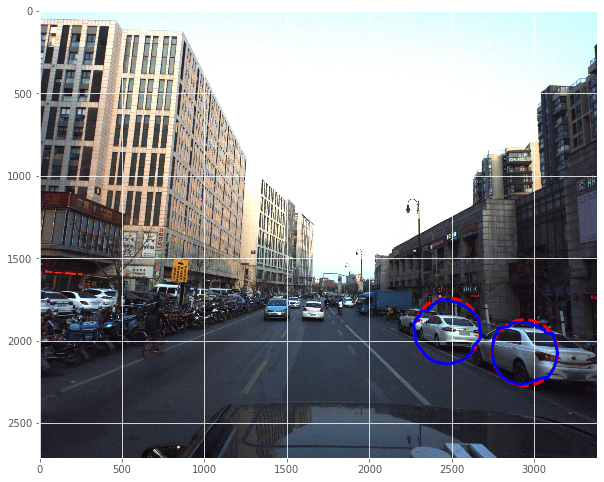

In [77]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    #ax.axis('off')
    return fig, ax

image_gray = color.rgb2gray(image_viz) 

def circle_points(resolution, center, radius):
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    return np.array([c, r]).T

fig, ax = image_show(image_viz)
for n in xy:
    points = circle_points(800, [n[1], n[0]], 200)[:-1]
    snake = seg.active_contour(image_gray, points, alpha = 0.06, beta = 0.3)
    ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)

# Other

In [22]:
train = pd.concat([train['ImageId'], train['PredictionString'].str.split(' ', expand=True)], axis=1)
train.co

,ImageId,0,1,2,3,4,5,6,7,8,...,298,299,300,301,302,303,304,305,306,307
0,ID_8a6e65317,16,0.254839,-2.57534,-3.10256,7.96539,3.20066,11.0225,56,0.181647,...,None,None,None,None,None,None,None,None,None,None
1,ID_337ddc495,66,0.163988,0.192169,-3.12112,-3.17424,6.55331,31.4339,60,0.112482,...,None,None,None,None,None,None,None,None,None,None
2,ID_a381bf4d0,43,0.162877,0.00519276,-3.02676,2.1876,3.53427,13.3436,51,0.158577,...,None,None,None,None,None,None,None,None,None,None
3,ID_7c4a3e0aa,43,0.126957,-3.04442,-3.10883,-14.738,24.6389,143.13,46,0.126956,...,None,None,None,None,None,None,None,None,None,None
4,ID_8b510fad6,37,0.16017,0.00862796,-3.0887,-3.04548,3.4977,12.9646,40,0.0740393,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,ID_de17ab626,70,0.177583,-0.023215,-3.08003,-25.3682,7.57325,47.8642,2,0.153805,...,None,None,None,None,None,None,None,None,None,None
4258,ID_5a669e211,12,0.23817,-3.12745,3.13929,-7.21988,3.09626,12.6917,16,0.166788,...,None,None,None,None,None,None,None,None,None,None
4259,ID_aa6ffba0a,35,0.166437,-0.497963,-3.12063,12.6792,5.48256,20.6109,8,0.169649,...,None,None,None,None,None,None,None,None,None,None
4260,ID_29454123f,70,0.14292,0.0290822,-3.12594,-3.42749,3.38674,13.1273,35,0.147919,...,None,None,None,None,None,None,None,None,None,None


In [2]:
train['PredictionString'][0]

NameError: name 'train' is not defined

In [ ]:
col_dir = 'train_images/*.jpg'
col = imread_collection(col_dir)

image = col[5] 
plt.imshow(image)

In [20]:
model = 'car_models/036-CAR01.pkl'

with open(model, "rb") as file:
    pickle.load(file, encoding="latin1")

ModuleNotFoundError: No module named 'objloader'